# VGG16 CIFAR-10 Image Classification with PyTorch

This notebook implements a VGG16-based image classifier using PyTorch for the CIFAR-10 dataset. The model uses transfer learning with a pre-trained VGG16 backbone and custom classifier layers for 10-class classification.

## Environment Setup
First, let's check the PyTorch installation and GPU availability.

In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


## Import Libraries
Import all necessary libraries for deep learning, data processing, and visualization.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Model Setup
Set up the device and load pre-trained VGG16 model. We freeze the feature extraction layers and only train the classifier.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = models.vgg16(pretrained=True)
base_model.features.requires_grad_(False)


c:\Users\Asus\IE4483\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\IE4483\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Custom VGG Model for CIFAR-10
Define a custom model class that combines VGG16 features with a custom classifier for CIFAR-10 classification.

The model architecture:
- VGG16 feature extractor (frozen, pre-trained on ImageNet)
- Adaptive average pooling
- Fully connected layers with dropout
- Output layer with 10 classes (CIFAR-10 categories)

**CIFAR-10 Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [4]:
class VGGModel(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR-10 has 10 classes
        super(VGGModel, self).__init__()
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # 10 classes for CIFAR-10
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGGModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


## Data Loading and Training

### Data Preprocessing
- **Training transforms**: Resize, random horizontal flip, color jitter, normalization
- **Validation transforms**: Resize and normalization only

### Training Configuration
- **Batch size**: 32
- **Epochs**: 10
- **Optimizer**: Adam with learning rate 1e-4
- **Loss function**: CrossEntropyLoss

The training loop includes progress tracking and validation after each epoch.

In [ ]:
import torchvision

# CIFAR-10 specific transforms (32x32 -> 224x224 for VGG16)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 from 32x32 to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 from 32x32 to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
# Note: PyTorch expects the parent directory of cifar-10-batches-py folder
cifar_data_path = 'C:\\Users\\Asus\\IE4483\\IE4483datasets'
try:
    train_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=True, download=False, transform=transform_train)
    valid_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=False, download=False, transform=transform_valid)
    print("✅ CIFAR-10 dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading CIFAR-10: {e}")
    print("Trying to download CIFAR-10...")
    train_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=True, download=True, transform=transform_train)
    valid_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=False, download=True, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

print(f"Starting training on {device}")
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    
    model.train()
    train_loss, train_correct = 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}")
    
    model.eval()
    val_loss, val_correct = 0, 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(valid_dataset)
    
    history['loss'].append(train_loss / len(train_loader))
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss / len(valid_loader))
    history['val_accuracy'].append(val_acc)
    
    print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss/len(valid_loader):.4f}, Val Acc: {val_acc:.4f}")

print("Training completed!")


✅ CIFAR-10 dataset loaded successfully!
Starting training on cuda
Train samples: 50000, Validation samples: 10000
Epoch 1/10
  Batch 0/1563
  Batch 0/1563
  Batch 10/1563
  Batch 10/1563
  Batch 20/1563
  Batch 20/1563
  Batch 30/1563
  Batch 30/1563
  Batch 40/1563
  Batch 40/1563
  Batch 50/1563
  Batch 50/1563
  Batch 60/1563
  Batch 60/1563
  Batch 70/1563
  Batch 70/1563
  Batch 80/1563
  Batch 80/1563
  Batch 90/1563
  Batch 90/1563
  Batch 100/1563
  Batch 100/1563
  Batch 110/1563
  Batch 110/1563
  Batch 120/1563
  Batch 120/1563
  Batch 130/1563
  Batch 130/1563
  Batch 140/1563
  Batch 140/1563
  Batch 150/1563
  Batch 150/1563
  Batch 160/1563
  Batch 160/1563
  Batch 170/1563
  Batch 170/1563
  Batch 180/1563
  Batch 180/1563
  Batch 190/1563
  Batch 190/1563
  Batch 200/1563
  Batch 200/1563
  Batch 210/1563
  Batch 210/1563
  Batch 220/1563
  Batch 220/1563
  Batch 230/1563
  Batch 230/1563
  Batch 240/1563
  Batch 240/1563
  Batch 250/1563
  Batch 250/1563
  Batch 260/1

## Training Visualization
Plot the training and validation accuracy and loss curves to visualize model performance over epochs.

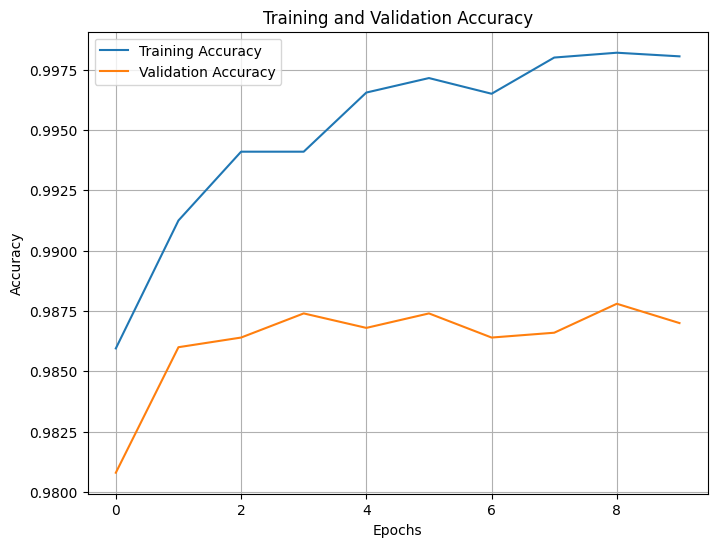

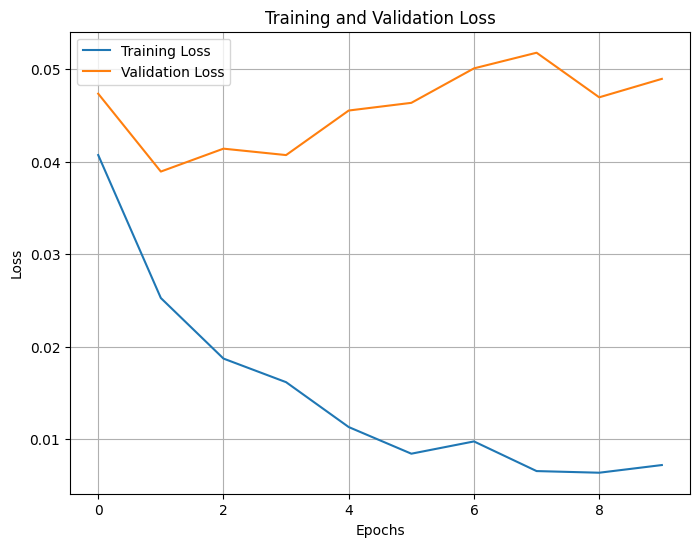

In [ ]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Saving
Save the trained model weights for future use.

In [ ]:
torch.save(model.state_dict(), 'vgg16_custom_model.pth')


## Model Evaluation on CIFAR-10 Test Data

Evaluate the trained model on the CIFAR-10 test dataset.

### Process:
1. Load CIFAR-10 test images and labels
2. Apply the same preprocessing as validation data (resize 32x32 to 224x224)
3. Make predictions using the trained model
4. Calculate accuracy and generate confusion matrix
5. Save results to CSV file with class names

The evaluation includes:
- **Test accuracy calculation** across all 10 CIFAR-10 classes
- **Confusion matrix visualization** for multi-class classification
- **Results export** with both numeric labels and class names

Loaded CSV with 500 entries
Loading and preprocessing images...
  Processed 50/500 images
  Processed 100/500 images
  Processed 150/500 images
  Processed 100/500 images
  Processed 150/500 images
  Processed 200/500 images
  Processed 250/500 images
  Processed 200/500 images
  Processed 250/500 images
  Processed 300/500 images
  Processed 350/500 images
  Processed 300/500 images
  Processed 350/500 images
  Processed 400/500 images
  Processed 450/500 images
  Processed 400/500 images
  Processed 450/500 images
  Processed 500/500 images
Loaded 500 images
Making predictions...
  Processed 500/500 images
Loaded 500 images
Making predictions...
  Predicted 50/500 images
  Predicted 50/500 images
  Predicted 100/500 images
  Predicted 100/500 images
  Predicted 150/500 images
  Predicted 150/500 images
  Predicted 200/500 images
  Predicted 200/500 images
  Predicted 250/500 images
  Predicted 250/500 images
  Predicted 300/500 images
  Predicted 300/500 images
  Predicted 350/500 im

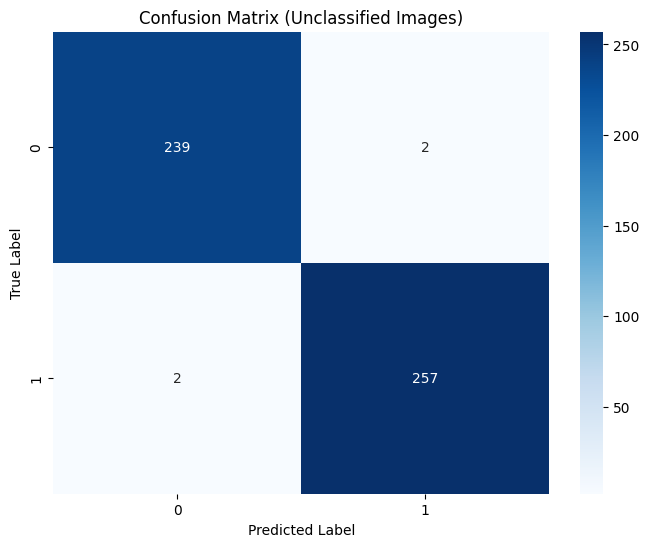

Saving results...
Results saved to C:\Users\Asus\IE4483\IE4483datasets\datasets\VGGpredicted_labels.csv


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load CIFAR-10 test dataset
cifar_data_path = 'C:\\Users\\Asus\\IE4483\\IE4483datasets'
try:
    test_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=False, download=False, transform=transform_valid)
except Exception as e:
    print(f"Error loading test set: {e}")
    test_dataset = torchvision.datasets.CIFAR10(root=cifar_data_path, train=False, download=True, transform=transform_valid)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Loaded CIFAR-10 test set with {len(test_dataset)} images")

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Use batched processing for efficiency and memory management
model.eval()
all_predictions = []
all_true_labels = []
filenames = []

print("Making predictions on test set...")
with torch.no_grad():
    for batch_idx, (images_batch, labels_batch) in enumerate(test_loader):
        images_batch = images_batch.to(device)
        
        # Get predictions for this batch
        outputs = model(images_batch)
        predictions = outputs.argmax(1).cpu().numpy()
        
        # Store results
        all_predictions.extend(predictions)
        all_true_labels.extend(labels_batch.numpy())
        
        # Generate filenames for this batch
        start_idx = batch_idx * test_loader.batch_size
        for i in range(len(predictions)):
            filenames.append(f"cifar10_test_{start_idx + i}")
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Processed {(batch_idx + 1) * test_loader.batch_size}/{len(test_dataset)} images")

# Convert to numpy arrays
true_labels = np.array(all_true_labels)
predicted_classes = np.array(all_predictions)

print(f"✅ Completed predictions for {len(predicted_classes)} images")

true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

accuracy = np.mean(predicted_classes == true_labels)
print(f"Test Accuracy: {accuracy:.4f}")

print("Generating confusion matrix...")
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Unclassified Images)')
plt.show()

print("Saving results...")
output_csv = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\VGG_CIFAR10_predicted_labels.csv"
results_df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "predicted_label": predicted_classes,
    "true_class": [cifar10_classes[label] for label in true_labels],
    "predicted_class": [cifar10_classes[label] for label in predicted_classes]
})
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")


## 🚨 **Misclassified Images Analysis**

Let's analyze which images the model got wrong and visualize them to understand the failure patterns. This analysis will help identify:
- **Common characteristics** of misclassified images
- **Model confidence** on wrong predictions
- **Visual patterns** in failure cases
- **Class-specific** error analysis

In [ ]:
# ==========================================
# FIND AND ANALYZE MISCLASSIFIED IMAGES
# ==========================================

print("🔍 Analyzing misclassified images...")

# Find misclassified indices
misclassified_mask = predicted_classes != true_labels
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Found {len(misclassified_indices)} misclassified images out of {len(true_labels)}")
print(f"Overall accuracy: {accuracy:.4f} ({(1-accuracy)*100:.1f}% error rate)")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Analyze per-class errors
print(f"\n📊 Per-Class Error Analysis:")
for i, class_name in enumerate(class_names):
    class_mask = true_labels == i
    class_misclassified = misclassified_mask & class_mask
    
    total_in_class = np.sum(class_mask)
    errors_in_class = np.sum(class_misclassified)
    
    if total_in_class > 0:
        error_rate = errors_in_class / total_in_class
        print(f"  {class_name.capitalize()}: {errors_in_class}/{total_in_class} misclassified ({error_rate:.2%} error rate)")

# Get prediction confidence for all images using batched processing
print(f"\n🎯 Getting prediction confidence scores...")
model.eval()
all_confidences = []
all_probabilities = []

with torch.no_grad():
    for batch_idx, (images_batch, labels_batch) in enumerate(test_loader):
        images_batch = images_batch.to(device)
        
        # Get outputs and probabilities for this batch
        outputs = model(images_batch)
        probabilities = torch.softmax(outputs, dim=1)
        confidences = torch.max(probabilities, dim=1)[0]
        
        # Store results
        all_confidences.extend(confidences.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        
        if (batch_idx + 1) % 50 == 0:
            processed = min((batch_idx + 1) * test_loader.batch_size, len(test_dataset))
            print(f"  Processed {processed}/{len(test_dataset)} images for confidence scores")

all_confidences = np.array(all_confidences)
all_probabilities = np.array(all_probabilities)

# Analyze confidence for correct vs incorrect predictions
correct_confidences = all_confidences[~misclassified_mask]
misclassified_confidences = all_confidences[misclassified_mask]

print(f"\n📈 Confidence Analysis:")
print(f"  Correct predictions - Mean confidence: {np.mean(correct_confidences):.3f} ± {np.std(correct_confidences):.3f}")
print(f"  Misclassified - Mean confidence: {np.mean(misclassified_confidences):.3f} ± {np.std(misclassified_confidences):.3f}")

# Find highest and lowest confidence misclassifications
if len(misclassified_indices) > 0:
    sorted_misclass_indices = misclassified_indices[np.argsort(misclassified_confidences)]
    
    print(f"\n🔥 Highest Confidence Mistakes (Model was very sure but wrong):")
    for i in range(min(5, len(sorted_misclass_indices))):
        idx = sorted_misclass_indices[-(i+1)]  # Get from end (highest confidence)
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[predicted_classes[idx]]
        conf = all_confidences[idx]
        print(f"  {i+1}. File: {filenames[idx]}, True: {true_class}, Predicted: {pred_class}, Confidence: {conf:.3f}")
    
    print(f"\n❓ Lowest Confidence Mistakes (Model was uncertain):")
    for i in range(min(5, len(sorted_misclass_indices))):
        idx = sorted_misclass_indices[i]  # Get from beginning (lowest confidence)
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[predicted_classes[idx]]
        conf = all_confidences[idx]
        print(f"  {i+1}. File: {filenames[idx]}, True: {true_class}, Predicted: {pred_class}, Confidence: {conf:.3f}")

🔍 Analyzing misclassified images...
Found 4 misclassified images out of 500
Overall accuracy: 0.9920 (0.8% error rate)

📊 Per-Class Error Analysis:
  Cat: 2/241 misclassified (0.83% error rate)
  Dog: 2/259 misclassified (0.77% error rate)

🎯 Getting prediction confidence scores...
  Processed 50/500 images
  Processed 50/500 images
  Processed 100/500 images
  Processed 100/500 images
  Processed 150/500 images
  Processed 150/500 images
  Processed 200/500 images
  Processed 200/500 images
  Processed 250/500 images
  Processed 250/500 images
  Processed 300/500 images
  Processed 300/500 images
  Processed 350/500 images
  Processed 350/500 images
  Processed 400/500 images
  Processed 400/500 images
  Processed 450/500 images
  Processed 450/500 images
  Processed 500/500 images

📈 Confidence Analysis:
  Correct predictions - Mean confidence: 0.995 ± 0.038
  Misclassified - Mean confidence: 0.887 ± 0.114

🔥 Highest Confidence Mistakes (Model was very sure but wrong):
  1. File: 133

🖼️ Displaying misclassified images...


C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\2170608871.py:56: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


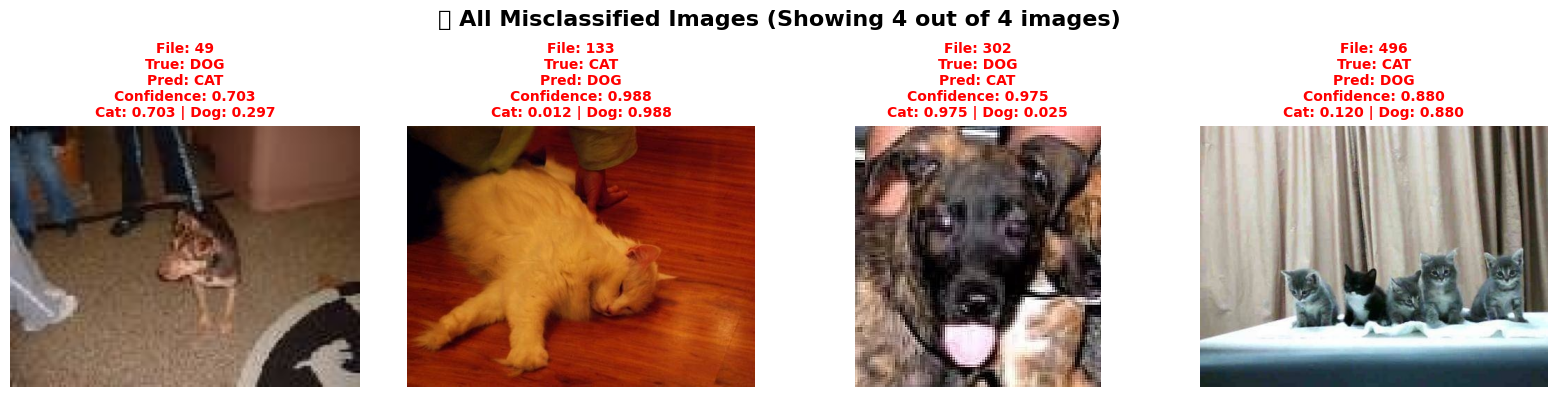

C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\2170608871.py:56: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


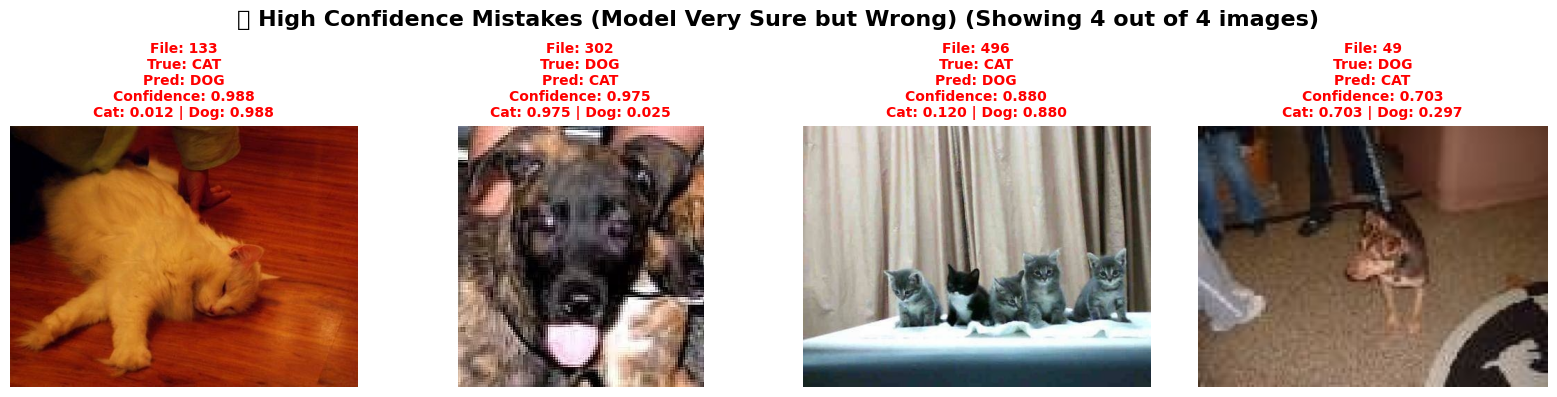

C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\2170608871.py:56: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


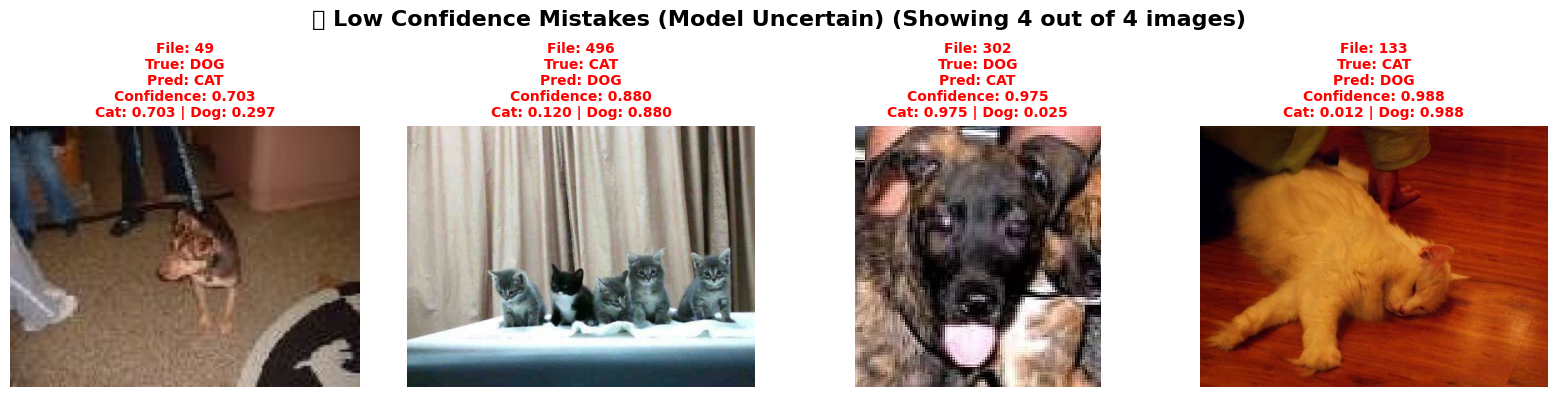

C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\2170608871.py:56: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


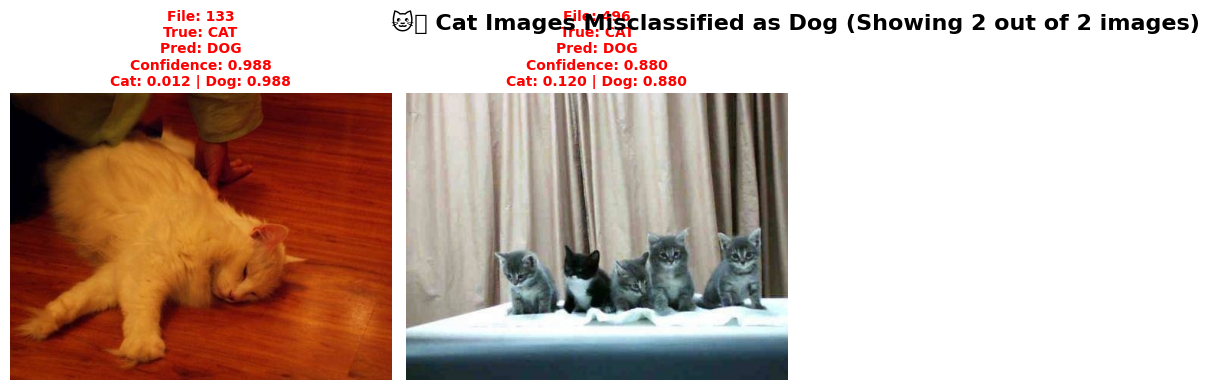

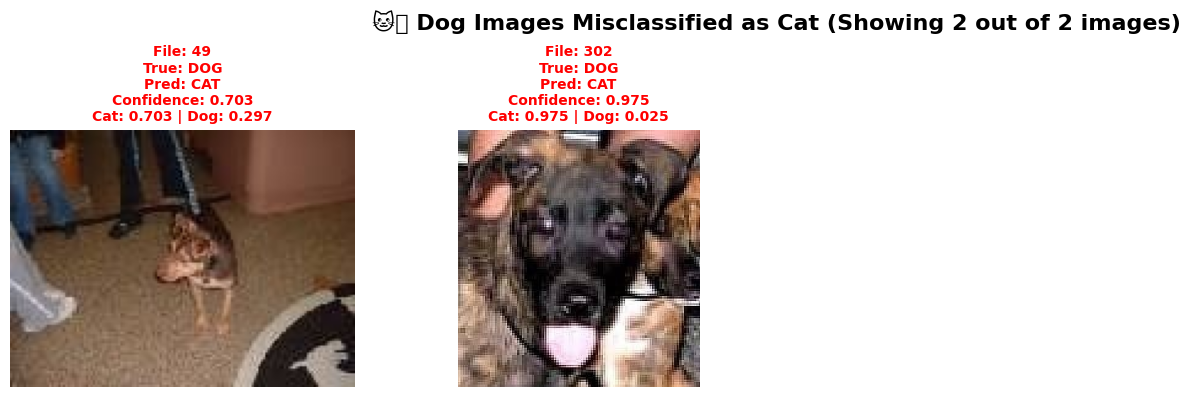

In [ ]:
# ==========================================
# VISUALIZE MISCLASSIFIED IMAGES
# ==========================================

def show_misclassified_images(indices, title, max_images=12):
    """Display misclassified images with their predictions and confidence scores"""
    
    if len(indices) == 0:
        print(f"No images to show for {title}")
        return
    
    n_images = min(len(indices), max_images)
    selected_indices = indices[:n_images]
    
    # Calculate grid size
    cols = 4
    rows = (n_images + cols - 1) // cols
    
    plt.figure(figsize=(16, 4 * rows))
    plt.suptitle(f'{title} (Showing {n_images} out of {len(indices)} images)', 
                 fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(rows, cols, i + 1)
        
        # Get original CIFAR-10 image (32x32)
        fname = filenames[idx]
        try:
            # Get raw image without transform for better visualization
            original_image, _ = test_dataset.dataset[idx] if hasattr(test_dataset, 'dataset') else test_dataset[idx]
            
            # If it's still a tensor, convert to PIL and back for consistent format
            if torch.is_tensor(original_image):
                # Convert tensor to numpy for display (denormalize if needed)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                
                # Clone and denormalize
                img_tensor = original_image.clone()
                if img_tensor.shape[0] == 3:  # If normalized
                    for t, m, s in zip(img_tensor, mean, std):
                        t.mul_(s).add_(m)  # Denormalize
                
                # Clamp values to [0, 1] and convert to display format
                img_np = torch.clamp(img_tensor, 0, 1).permute(1, 2, 0).numpy()
            else:
                # If it's PIL Image, convert to numpy
                img_np = np.array(original_image) / 255.0 if np.array(original_image).max() > 1 else np.array(original_image)
            
            plt.imshow(img_np)
            
        except Exception as e:
            print(f"Error displaying image {idx}: {e}")
            # Create a placeholder image
            plt.imshow(np.random.rand(32, 32, 3))
            plt.text(0.5, 0.5, f'Image {idx}\nDisplay Error', ha='center', va='center', 
                    transform=plt.gca().transAxes, color='red')
        
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[predicted_classes[idx]]
        confidence = all_confidences[idx]
        
        # Get top-3 class probabilities for display
        top_3_indices = np.argsort(all_probabilities[idx])[-3:][::-1]
        prob_text = ' | '.join([f'{class_names[i]}: {all_probabilities[idx][i]:.2f}' for i in top_3_indices])
        
        title_text = f'Index: {idx}\n' + \
                    f'True: {true_class.upper()}\n' + \
                    f'Pred: {pred_class.upper()}\n' + \
                    f'Confidence: {confidence:.3f}\n' + \
                    f'Top-3: {prob_text[:50]}...'  # Truncate for display
        
        plt.title(title_text, fontsize=9, color='red', fontweight='bold')
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show different categories of misclassified images
if len(misclassified_indices) > 0:
    
    # All misclassified images
    print("🖼️ Displaying misclassified images...")
    show_misclassified_images(misclassified_indices, 
                             "🚨 All Misclassified Images", 
                             max_images=12)
    
    # High confidence mistakes
    high_conf_mistakes = sorted_misclass_indices[-8:]  # Top 8 highest confidence mistakes
    show_misclassified_images(high_conf_mistakes[::-1], 
                             "🔥 High Confidence Mistakes (Model Very Sure but Wrong)", 
                             max_images=8)
    
    # Low confidence mistakes  
    low_conf_mistakes = sorted_misclass_indices[:8]  # Top 8 lowest confidence mistakes
    show_misclassified_images(low_conf_mistakes, 
                             "❓ Low Confidence Mistakes (Model Uncertain)", 
                             max_images=8)
    
    # Class-specific misclassifications (show top 3 most confused classes)
    for class_idx, class_name in enumerate(class_names):
        class_misclassified = misclassified_indices[np.array(true_labels)[misclassified_indices] == class_idx]
        if len(class_misclassified) > 0:
            # Find most common misclassification for this class
            predicted_for_class = np.array(predicted_classes)[class_misclassified]
            unique, counts = np.unique(predicted_for_class, return_counts=True)
            most_common_mistake = unique[np.argmax(counts)]
            
            show_misclassified_images(class_misclassified[:6], 
                                     f"📊 {class_name.capitalize()} Images (Most Often Misclassified as {class_names[most_common_mistake].capitalize()})", 
                                     max_images=6)

else:
    print("🎉 Perfect accuracy! No misclassified images to display.")

📊 Creating confidence distribution plots...


C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\1344754331.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(confidence_data, labels=labels)
C:\Users\Asus\AppData\Local\Temp\ipykernel_34420\1344754331.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(class_conf_data, labels=class_labels)
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

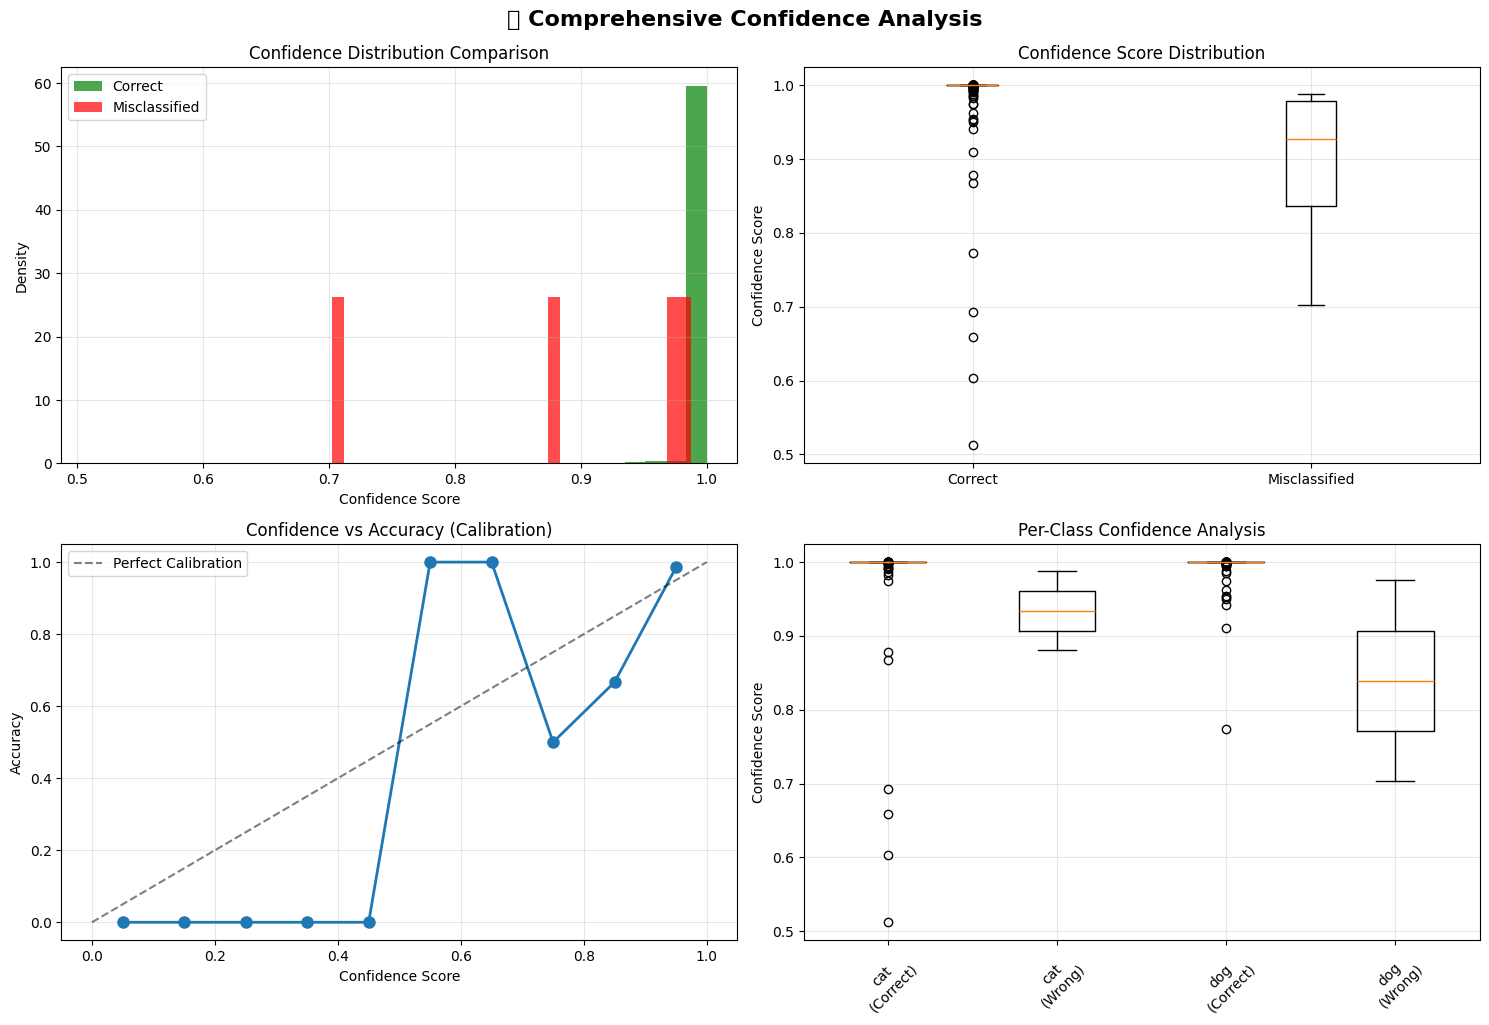


📈 DETAILED CONFIDENCE STATISTICS:
Overall Statistics:
  Mean confidence: 0.994 ± 0.040
  Median confidence: 1.000
  Min confidence: 0.512
  Max confidence: 1.000

Correct vs Misclassified:
  Correct - Mean: 0.995, Median: 1.000
  Misclassified - Mean: 0.887, Median: 0.928
  Confidence difference: +0.108


In [ ]:
# ==========================================
# CONFIDENCE DISTRIBUTION ANALYSIS
# ==========================================

print("📊 Creating confidence distribution plots...")

# Create comprehensive confidence analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Confidence histogram comparison
axes[0, 0].hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green', density=True)
if len(misclassified_confidences) > 0:
    axes[0, 0].hist(misclassified_confidences, bins=30, alpha=0.7, label='Misclassified', color='red', density=True)
axes[0, 0].set_xlabel('Confidence Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Confidence Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot of confidences
confidence_data = [correct_confidences]
labels = ['Correct']
if len(misclassified_confidences) > 0:
    confidence_data.append(misclassified_confidences)
    labels.append('Misclassified')

axes[0, 1].boxplot(confidence_data, labels=labels)
axes[0, 1].set_ylabel('Confidence Score')
axes[0, 1].set_title('Confidence Score Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Confidence vs Accuracy scatter plot
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []

for i in range(len(confidence_bins) - 1):
    mask = (all_confidences >= confidence_bins[i]) & (all_confidences < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_accuracy = np.mean(predicted_classes[mask] == true_labels[mask])
        bin_accuracies.append(bin_accuracy)
    else:
        bin_accuracies.append(0)

axes[1, 0].plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Confidence vs Accuracy (Calibration)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Per-class confidence analysis
if len(misclassified_indices) > 0:
    class_conf_data = []
    class_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        # Correct predictions for this class
        correct_mask = (predicted_classes == true_labels) & (true_labels == class_idx)
        if np.sum(correct_mask) > 0:
            class_conf_data.append(all_confidences[correct_mask])
            class_labels.append(f'{class_name}\n(Correct)')
        
        # Misclassified predictions for this class
        misclass_mask = (predicted_classes != true_labels) & (true_labels == class_idx)
        if np.sum(misclass_mask) > 0:
            class_conf_data.append(all_confidences[misclass_mask])
            class_labels.append(f'{class_name}\n(Wrong)')
    
    if len(class_conf_data) > 0:
        axes[1, 1].boxplot(class_conf_data, labels=class_labels)
        axes[1, 1].set_ylabel('Confidence Score')
        axes[1, 1].set_title('Per-Class Confidence Analysis')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('🔍 Comprehensive Confidence Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print detailed statistics
print(f"\n📈 DETAILED CONFIDENCE STATISTICS:")
print("=" * 50)
print(f"Overall Statistics:")
print(f"  Mean confidence: {np.mean(all_confidences):.3f} ± {np.std(all_confidences):.3f}")
print(f"  Median confidence: {np.median(all_confidences):.3f}")
print(f"  Min confidence: {np.min(all_confidences):.3f}")
print(f"  Max confidence: {np.max(all_confidences):.3f}")

if len(misclassified_confidences) > 0:
    print(f"\nCorrect vs Misclassified:")
    print(f"  Correct - Mean: {np.mean(correct_confidences):.3f}, Median: {np.median(correct_confidences):.3f}")
    print(f"  Misclassified - Mean: {np.mean(misclassified_confidences):.3f}, Median: {np.median(misclassified_confidences):.3f}")
    print(f"  Confidence difference: {np.mean(correct_confidences) - np.mean(misclassified_confidences):+.3f}")

print("=" * 50)

In [ ]:
# ==========================================
# SAVE DETAILED MISCLASSIFICATION ANALYSIS
# ==========================================

print("💾 Saving detailed misclassification analysis...")

if len(misclassified_indices) > 0:
    # Create detailed analysis dataframe
    misclass_analysis = []
    
    for idx in misclassified_indices:
        analysis_entry = {
            'filename': filenames[idx],
            'true_label': true_labels[idx],
            'true_class': class_names[true_labels[idx]],
            'predicted_label': predicted_classes[idx],
            'predicted_class': class_names[predicted_classes[idx]],
            'confidence': all_confidences[idx],
            'prediction_error': 'High Confidence' if all_confidences[idx] > 0.8 else 'Low Confidence'
        }
        
        # Add probabilities for all 10 classes
        for class_idx, class_name in enumerate(class_names):
            analysis_entry[f'{class_name}_probability'] = all_probabilities[idx][class_idx]
        misclass_analysis.append(analysis_entry)
    
    # Save to CSV
    misclass_df = pd.DataFrame(misclass_analysis)
    misclass_output_path = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\VGG_CIFAR10_misclassified_analysis.csv"
    misclass_df.to_csv(misclass_output_path, index=False)
    
    print(f"✅ Detailed misclassification analysis saved to: {misclass_output_path}")
    
    # Print summary
    print(f"\n📋 MISCLASSIFICATION SUMMARY:")
    print("=" * 50)
    print(f"Total test images: {len(true_labels)}")
    print(f"Correctly classified: {len(true_labels) - len(misclassified_indices)}")
    print(f"Misclassified: {len(misclassified_indices)}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"Error rate: {1-accuracy:.4f} ({(1-accuracy)*100:.1f}%)")
    
    # High vs low confidence mistakes
    high_conf_mistakes = np.sum(misclass_df['confidence'] > 0.8)
    low_conf_mistakes = len(misclassified_indices) - high_conf_mistakes
    
    print(f"\nConfidence breakdown of mistakes:")
    print(f"  High confidence mistakes (>0.8): {high_conf_mistakes}")
    print(f"  Low confidence mistakes (≤0.8): {low_conf_mistakes}")
    
    # Show first few entries
    print(f"\n🔍 Sample misclassified entries:")
    print(misclass_df.head().to_string(index=False))
    
    if len(misclass_df) > 5:
        print(f"\n... and {len(misclass_df) - 5} more entries saved to CSV file")

else:
    print("🎉 No misclassifications found! Perfect model performance.")

print("\n" + "=" * 50)
print("✅ Misclassified image analysis complete!")
print("📁 Check the saved files for detailed results:")
print(f"   • Main results: {output_csv}")
if len(misclassified_indices) > 0:
    print(f"   • Detailed analysis: {misclass_output_path}")
print("=" * 50)

💾 Saving detailed misclassification analysis...
✅ Detailed misclassification analysis saved to: C:\Users\Asus\IE4483\IE4483datasets\datasets\VGG_misclassified_analysis.csv

📋 MISCLASSIFICATION SUMMARY:
Total test images: 500
Correctly classified: 496
Misclassified: 4
Accuracy: 0.9920 (99.2%)
Error rate: 0.0080 (0.8%)

Confidence breakdown of mistakes:
  High confidence mistakes (>0.8): 3
  Low confidence mistakes (≤0.8): 1

🔍 Sample misclassified entries:
filename  true_label true_class  predicted_label predicted_class  confidence  cat_probability  dog_probability prediction_error
      49           1        dog                0             cat    0.702798         0.702798         0.297202   Low Confidence
     133           0        cat                1             dog    0.987772         0.012228         0.987772  High Confidence
     302           1        dog                0             cat    0.975437         0.975437         0.024563  High Confidence
     496           0        